In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import glob
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import RandomSearch
import pathlib

In [2]:
dataset_dir = "/kaggle/input/disease-models/Disease_Models_Dataset/Corn"
data_dir = pathlib.Path(dataset_dir).with_suffix('')

classes = os.listdir(dataset_dir)

In [3]:
# Count the number of images in each class
image_counts = []
for class_name in classes:
    class_dir = data_dir / class_name
    if os.path.isdir(class_dir):
        num_images = len(os.listdir(class_dir))
        image_counts.append(num_images)
    else:
        image_counts.append(0)

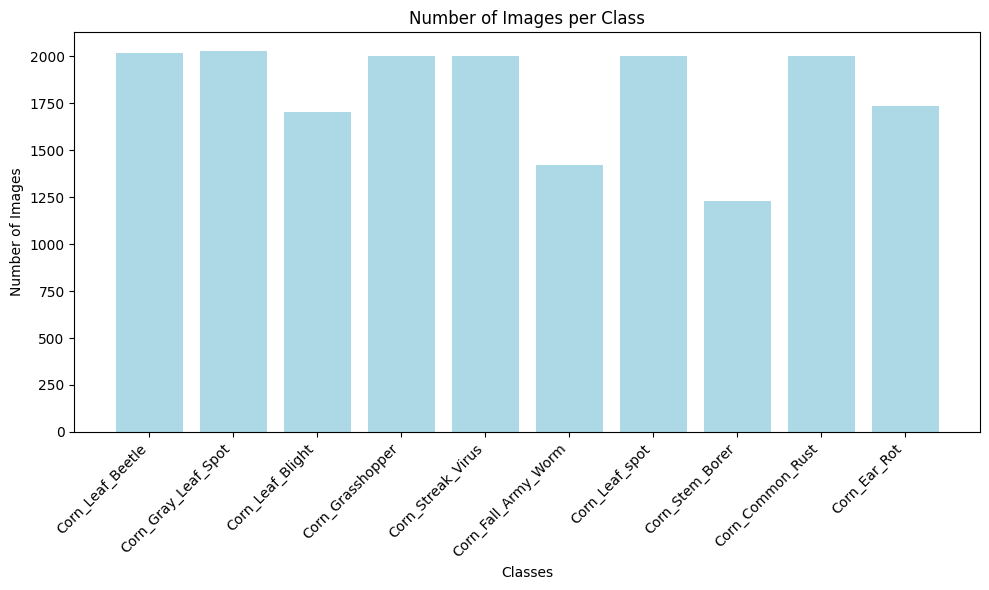

In [4]:
plt.figure(figsize=(10, 6))
plt.bar(classes, image_counts, color='lightblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.xticks(rotation=45, ha='right')  # Rotate class names for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [5]:
batch_size = 14
img_height = 224
img_width = 224

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18155 files belonging to 10 classes.
Using 14524 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18155 files belonging to 10 classes.
Using 3631 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Corn_Common_Rust', 'Corn_Ear_Rot', 'Corn_Fall_Army_Worm', 'Corn_Grasshopper', 'Corn_Gray_Leaf_Spot', 'Corn_Leaf_Beetle', 'Corn_Leaf_Blight', 'Corn_Leaf_spot', 'Corn_Stem_Borer', 'Corn_Streak_Virus']


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

In [11]:
num_classes = len(class_names)

In [12]:
def build_model(hp):
    # Hyperparameters to tune
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    num_units = hp.Int('num_units', min_value=128, max_value=512, step=128)
    
    # Load ResNet50 with include_top=False
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = 100
    
    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False  # Freeze the base model

    # Build the model
    model = Sequential([
        # layers.Rescaling(1./255, input_shape=(height, width, channels)),
        base_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [13]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',  # Metric to optimize
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of models to train per trial (for robustness)
    directory='keras_tuner_dir',  # Directory to save results
    project_name='plant_village_tuning'  # Project name
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [14]:
# Define early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    restore_best_weights=True)

In [ ]:
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping]
)

Trial 2 Complete [00h 09m 36s]
val_accuracy: 0.968052864074707

Best val_accuracy So Far: 0.968052864074707
Total elapsed time: 00h 19m 30s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
1e-05             |0.0001            |learning_rate
0                 |0.1               |dropout_rate
512               |128               |num_units

Epoch 1/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 92s 65ms/step - accuracy: 0.5935 - loss: 2.0939 - val_accuracy: 0.9199 - val_loss: 1.0716
Epoch 2/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.9370 - loss: 1.0416 - val_accuracy: 0.9479 - val_loss: 0.9659
Epoch 3/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.9883 - loss: 0.8693 - val_accuracy: 0.9532 - val_loss: 0.9386
Epoch 4/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 53s 51ms/step - accuracy: 0.9975 - loss: 0.8052 - val_accuracy: 0.9529 - val_loss: 0.9235
Epoch 5/10
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 54s 52ms/step - accuracy: 0.9994 - loss: 0.7662 - val_accu

In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Best hyperparameters:
- Learning rate: {best_hps.get('learning_rate')}
- Dropout rate: {best_hps.get('dropout_rate')}
- Number of units: {best_hps.get('num_units')}
""")

# Build the model with the best hyperparameters
# best_model = build_model(best_hps)
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy}")

In [ ]:
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,  # You can increase epochs for final training
    callbacks=[early_stopping]
)

In [ ]:
all_images = []
all_labels = []

for images, labels in val_ds:
    all_images.append(images)
    all_labels.append(labels)

all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

In [ ]:
predictions = best_model.predict(all_images)

y_pred = np.argmax(predictions, axis=1)
y_true = all_labels

In [ ]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
best_model.save('apple_bell_pepper.keras')

In [ ]:
loaded_model = tf.keras.models.load_model('/kaggle/working/apple_bell_pepper.keras')

In [ ]:
img_path = "/kaggle/input/test-images-10/Test Images/Apple___Cedar_apple_rust.jpg"

img = tf.keras.utils.load_img(
    img_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  


predictions = loaded_model.predict(img_array)

score = tf.nn.softmax(predictions[0])

max_index = np.argmax(score)
max_class_name = class_names[max_index]
max_score = score[max_index]

print(f"\nThis image belongs to {max_class_name} with a {int((max_score * 100))}% confidence.",)

In [ ]:
from IPython.display import FileLink 
FileLink('apple_bell_pepper.keras')